## Following the results of our training/testing on data from a single camera, we now test our models with a dataset containing frames from a wide array of cameras

In [5]:
import os
import numpy as np
from sklearn.model_selection import train_test_split
import sklearn
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
import matplotlib
import platform
import time

In [4]:
# Constants used throughout the code
IMG_HEIGHT = 224
IMG_WIDTH = 224
BATCH_SIZE = 64  # Increased batch size for faster processing
EPOCHS = 20     # Change back to higher after tests

In [24]:
def load_and_preprocess_images(directory, max_per_class=None):
    """
    Load and preprocess images with an optional limit per class.
    Args:
        directory: Base directory containing 'blocked' and 'notblocked' subdirectories
        max_per_class: Max number of images to load per class (if None, load all).  Used for testing.
    """
    
    # where I store the image files and their corresponding labels
    images = []
    labels = []
    
    print("\nLoading images with blocked bike lanes:")
    
    # Load blocked images
    blocked_dir = os.path.join(directory, 'blocked3')
    blocked_files = [f for f in os.listdir(blocked_dir) if f.lower().endswith('.png')]
    if max_per_class:
        blocked_files = blocked_files[:max_per_class]
    
    for i, img_name in enumerate(blocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing blocked image {i}/{len(blocked_files)}")
        img_path = os.path.join(blocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(1)  # 1 for blocked
    
    print("\nLoading images with unblocked bike lanes:")
    
    # Load not blocked images
    notblocked_dir = os.path.join(directory, 'notblocked3')
    notblocked_files = [f for f in os.listdir(notblocked_dir) if f.lower().endswith('.png')]
    if max_per_class:
        notblocked_files = notblocked_files[:max_per_class]
    
    for i, img_name in enumerate(notblocked_files, 1):
        if i % 25 == 0:  # Show progress every 10 images
            print(f"Processing non-blocked image {i}/{len(notblocked_files)}")
        img_path = os.path.join(notblocked_dir, img_name)
        # Load the image using Keras' load_img and then convert it to an array
        img = load_img(img_path, target_size=(IMG_HEIGHT, IMG_WIDTH))
        img_array = img_to_array(img)
        images.append(img_array)
        labels.append(0)  # 0 for not blocked
    
    return np.array(images), np.array(labels)

In [15]:

def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model

In [8]:
def normalize_images(images):
    """Normalize image pixel values to [0,1] range."""
    return images.astype('float32') / 255.0

def split_dataset(images, labels, test_size=0.2, random_state=42):
    """Split dataset into training and testing sets."""
    return train_test_split(
        images, labels, test_size=test_size, random_state=random_state
    )

def setup_gpu():
    """Configure GPU settings for Metal acceleration."""
    tf.config.experimental.set_visible_devices(
        tf.config.list_physical_devices('GPU'),
        'GPU'
    )

In [16]:
def train_model(model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2):
    """Train the model and return training history."""
    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")
    print(f"Using {validation_split*100}% of training data for validation")
    
    class TrainingProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            print(f"\nEpoch {epoch + 1}/{epochs}")
        
        def on_batch_end(self, batch, logs=None):
            if batch % 5 == 0:  # Show progress every 5 batches
                print(".", end="", flush=True)
    
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[TrainingProgressCallback()],
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test data and return metrics."""
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Evaluation complete!")
    return metrics

In [17]:
def plot_training_history(history):
    """Plot training and validation metrics."""
    print("\nGenerating training history plots...")
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    print("Displaying plots...")
    plt.show()

def print_versions():
    """Print versions of important packages."""
    print("\nPackage versions:")
    print(f"Python: {platform.python_version()}")
    print(f"TensorFlow: {tf.__version__}")
    print(f"NumPy: {np.__version__}")
    print(f"Scikit-learn: {sklearn.__version__}")
    print(f"Matplotlib: {matplotlib.__version__}")
    print(f"Keras: {tf.keras.__version__}")
    
    # Print GPU information if available
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        print("\nGPU Information:")
        for gpu in gpus:
            print(f"  {gpu}")
    print("\n")

In [18]:
def run():
    # Print version information for the libraries
    print_versions()

    # 1. Load and preprocess images
    print("\n" + "="*50)
    print("Step 1: Loading and preprocessing images...")

    # load the images and preprocess them with Keras util functions. 
    # send the root folder that contains the blocked and notblocked 
    images, labels = load_and_preprocess_images('../data2')  
    print("Normalizing images...")
    images = normalize_images(images)

    # 2. Split the dataset
    print("\n" + "="*50)
    print("Step 2: Splitting dataset into training and testing sets...")
    X_train, X_test, y_train, y_test = split_dataset(images, labels, test_size=0.2)

    print(f"\nDataset sizes:")
    print(f"Training images: {len(X_train)}")
    print(f"Testing images: {len(X_test)}")

    # 3. Create and compile the model
    print("\n" + "="*50)
    print("Step 3: Creating and compiling model...")
    model = create_model()
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    # 4. Train the model
    print("\n" + "="*50)
    print("Step 4: Training model...")
    history = train_model(model, X_train, y_train)

    # 5. Evaluate the model
    print("\n" + "="*50)
    print("Step 5: Evaluating model...")
    metrics = evaluate_model(model, X_test, y_test)
    print(f"\nTest accuracy: {metrics['test_accuracy']:.4f}")
    print(f"Test loss: {metrics['test_loss']:.4f}")

    # 6. Plot training history
    print("\n" + "="*50)
    print("Step 6: Plotting training history...")
    plot_training_history(history)


Package versions:
Python: 3.9.18
TensorFlow: 2.16.2
NumPy: 1.26.4
Scikit-learn: 1.5.2
Matplotlib: 3.9.3
Keras: 3.7.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/4131
Processing blocked image 50/4131
Processing blocked image 75/4131
Processing blocked image 100/4131
Processing blocked image 125/4131
Processing blocked image 150/4131
Processing blocked image 175/4131
Processing blocked image 200/4131
Processing blocked image 225/4131
Processing blocked image 250/4131
Processing blocked image 275/4131
Processing blocked image 300/4131
Processing blocked image 325/4131
Processing blocked image 350/4131
Processing blocked image 375/4131
Processing blocked image 400/4131
Processing blocked image 425/4131
Processing blocked image 450/4131
Processing blocked image 475/4131
Processing blocked image 500/4131
Processing blocked image 525/413

/Users/nickmeeks/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-09 14:17:15.897376: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2024-12-09 14:17:15.897647: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2024-12-09 14:17:15.897812: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2024-12-09 14:17:15.898661: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-09 14:17:15.899045: I tensorflow/core/common_runtime/pluggable_device/pluggable_


Step 4: Training model...

Training with 20 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/20


2024-12-09 14:17:21.134719: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


................
Epoch 2/20
................
Epoch 3/20
................
Epoch 4/20
................
Epoch 5/20
................
Epoch 6/20
................
Epoch 7/20
................
Epoch 8/20
................
Epoch 9/20
................
Epoch 10/20
................
Epoch 11/20
................
Epoch 12/20
................
Epoch 13/20
................
Epoch 14/20
................
Epoch 15/20
................
Epoch 16/20
................
Epoch 17/20
................
Epoch 18/20
................
Epoch 19/20
................
Epoch 20/20
................
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.7811
Test loss: 1.1134

Step 6: Plotting training history...

Generating training history plots...
Displaying plots...


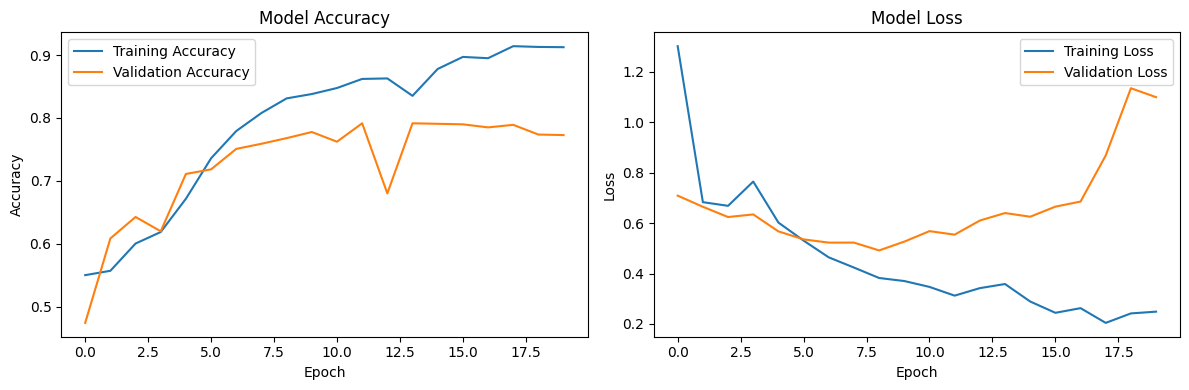

In [25]:
run()

### Implementing Early Stopping to avoid unnecessary computation, and implementing dropout to see if accuracy increases

In [26]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',  # Metric to monitor
    patience=5,              # Number of epochs to wait before stopping
    min_delta=0.01,          # Minimum change in the monitored metric to qualify as an improvement
    restore_best_weights=True  # Restore model weights from the best epoch
)

In [27]:
def train_model(model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2):
    """Train the model and return training history."""
    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")
    print(f"Using {validation_split*100}% of training data for validation")
    
    class TrainingProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            print(f"\nEpoch {epoch + 1}/{epochs}")
        
        def on_batch_end(self, batch, logs=None):
            if batch % 5 == 0:  # Show progress every 5 batches
                print(".", end="", flush=True)
    
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[TrainingProgressCallback(), early_stopping], # ADDED EARLY STOPPING
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test data and return metrics."""
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Evaluation complete!")
    return metrics

In [28]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.25),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Fourth Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.5), # higher dropout rate because it's a Dense
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


Package versions:
Python: 3.9.18
TensorFlow: 2.16.2
NumPy: 1.26.4
Scikit-learn: 1.5.2
Matplotlib: 3.9.3
Keras: 3.7.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/4131
Processing blocked image 50/4131
Processing blocked image 75/4131
Processing blocked image 100/4131
Processing blocked image 125/4131
Processing blocked image 150/4131
Processing blocked image 175/4131
Processing blocked image 200/4131
Processing blocked image 225/4131
Processing blocked image 250/4131
Processing blocked image 275/4131
Processing blocked image 300/4131
Processing blocked image 325/4131
Processing blocked image 350/4131
Processing blocked image 375/4131
Processing blocked image 400/4131
Processing blocked image 425/4131
Processing blocked image 450/4131
Processing blocked image 475/4131
Processing blocked image 500/4131
Processing blocked image 525/413

/Users/nickmeeks/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Step 4: Training model...

Training with 20 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/20
................
Epoch 2/20
................
Epoch 3/20
................
Epoch 4/20
................
Epoch 5/20
................
Epoch 6/20
................
Epoch 7/20
................
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.6111
Test loss: 0.6737

Step 6: Plotting training history...

Generating training history plots...
Displaying plots...


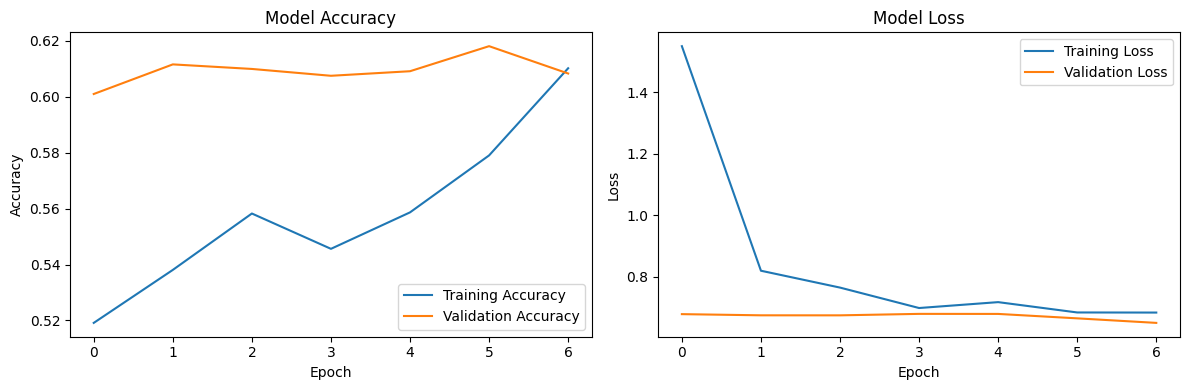

In [29]:
run()

### Trying without early stopping, increasing dropout

In [32]:
def train_model(model, X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2):
    """Train the model and return training history."""
    print(f"\nTraining with {epochs} epochs, batch size {batch_size}")
    print(f"Using {validation_split*100}% of training data for validation")
    
    class TrainingProgressCallback(tf.keras.callbacks.Callback):
        def on_epoch_begin(self, epoch, logs=None):
            print(f"\nEpoch {epoch + 1}/{epochs}")
        
        def on_batch_end(self, batch, logs=None):
            if batch % 5 == 0:  # Show progress every 5 batches
                print(".", end="", flush=True)
    
    return model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_split=validation_split,
        callbacks=[TrainingProgressCallback()],
        verbose=0
    )

def evaluate_model(model, X_test, y_test):
    """Evaluate model on test data and return metrics."""
    print("\nEvaluating model on test data...")
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
    metrics = {
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    }
    print(f"Evaluation complete!")
    return metrics
    

In [33]:
def create_model():
    """
    Creates a CNN model for binary image classification (blocked vs not blocked).
    Architecture: 3 Conv2D layers with max pooling, followed by dense layers.
    """
    model = models.Sequential([
        # First Convolutional Layer
        # 32 filters of size 3x3, ReLU activation
        # Input shape: 224x224 RGB images (3 channels)
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
        # Max Pooling: Reduces spatial dimensions by half (112x112)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Second Convolutional Layer
        # 64 filters of size 3x3, increased filters for more feature detection
        layers.Conv2D(64, (3, 3), activation='relu'),
        # Max Pooling: Further reduces dimensions (56x56)
        layers.MaxPooling2D((2, 2)),
        layers.Dropout(0.3),
        
        # Third Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),

        # Fourth Convolutional Layer
        # 64 filters of size 3x3, maintains number of filters
        layers.Conv2D(64, (3, 3), activation='relu'),
        
        # Flatten: Converts 3D feature maps to 1D vector
        layers.Flatten(),
        
        # Dense Layer: 64 neurons for high-level feature combination
        layers.Dense(64, activation='relu'),
        layers.Dropout(0.6), # higher dropout rate because it's a Dense
        
        # Output Layer: Single neuron with sigmoid for binary classification
        # Output: 0 (not blocked) or 1 (blocked)
        layers.Dense(1, activation='sigmoid')
    ])
    
    return model


Package versions:
Python: 3.9.18
TensorFlow: 2.16.2
NumPy: 1.26.4
Scikit-learn: 1.5.2
Matplotlib: 3.9.3
Keras: 3.7.0

GPU Information:
  PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')



Step 1: Loading and preprocessing images...

Loading images with blocked bike lanes:
Processing blocked image 25/4131
Processing blocked image 50/4131
Processing blocked image 75/4131
Processing blocked image 100/4131
Processing blocked image 125/4131
Processing blocked image 150/4131
Processing blocked image 175/4131
Processing blocked image 200/4131
Processing blocked image 225/4131
Processing blocked image 250/4131
Processing blocked image 275/4131
Processing blocked image 300/4131
Processing blocked image 325/4131
Processing blocked image 350/4131
Processing blocked image 375/4131
Processing blocked image 400/4131
Processing blocked image 425/4131
Processing blocked image 450/4131
Processing blocked image 475/4131
Processing blocked image 500/4131
Processing blocked image 525/413

/Users/nickmeeks/.pyenv/versions/3.9.18/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



Step 4: Training model...

Training with 20 epochs, batch size 64
Using 20.0% of training data for validation

Epoch 1/20
................
Epoch 2/20
................
Epoch 3/20
................
Epoch 4/20
................
Epoch 5/20
................
Epoch 6/20
................
Epoch 7/20
................
Epoch 8/20
................
Epoch 9/20
................
Epoch 10/20
................
Epoch 11/20
................
Epoch 12/20
................
Epoch 13/20
................
Epoch 14/20
................
Epoch 15/20
................
Epoch 16/20
................
Epoch 17/20
................
Epoch 18/20
................
Epoch 19/20
................
Epoch 20/20
................
Step 5: Evaluating model...

Evaluating model on test data...
Evaluation complete!

Test accuracy: 0.6163
Test loss: 0.6290

Step 6: Plotting training history...

Generating training history plots...
Displaying plots...


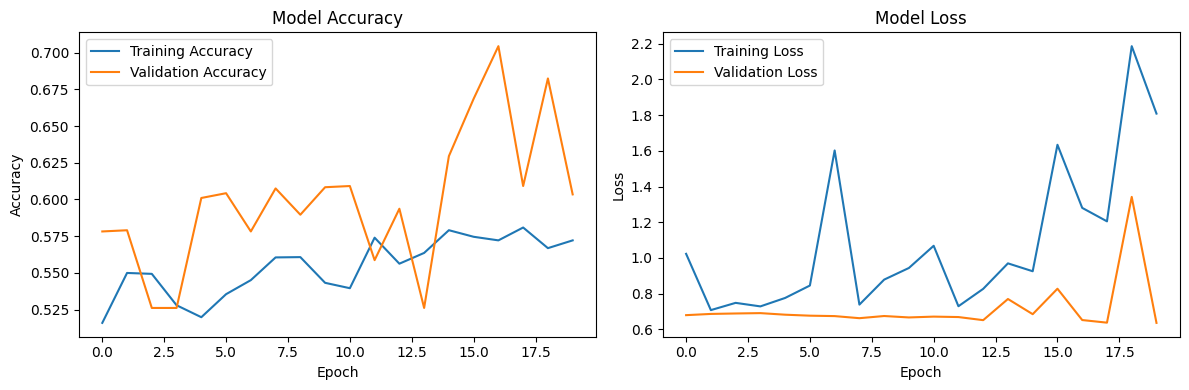

In [34]:
run()